In [1]:
using Distributions
using StatsPlots
using StatsBase

In [2]:
x ⪅ y = x < y || x ≈ y
safediv(x, y) = x == 0 ? x : x/y

function pval_fisher(a, b, c, d)
    hg = Hypergeometric(a+b, c+d, a+c)
    min(1, sum(pdf(hg, j) for j in support(hg) if pdf(hg, j) ⪅ pdf(hg, a)))
end

function pval_fisher_dos(a, b, c, d)
    hg = Hypergeometric(a+b, c+d, a+c)
    min(1, 2cdf(hg, a), 2ccdf(hg, a-1))
end

function chisqstat(a, b, c, d)
    N = a + b + c + d
    safediv(N*(a*d - b*c)^2, (a + b)*(c + d)*(a + c)*(b + d))
end

function chisqstat_yates(a, b, c, d)
    N = a + b + c + d
    safediv(N*(max(0, abs(a*d - b*c) - N/2))^2, (a + b)*(c + d)*(a + c)*(b + d))
end

function pval_chisq(a, b, c, d)
    X² = chisqstat(a, b, c, d)
    ccdf(Chisq(1), X²)
end

function pval_chisq_yates(a, b, c, d)
    X² = chisqstat_yates(a, b, c, d)
    ccdf(Chisq(1), X²)
end

for f in (:pval_fisher, :pval_fisher_dos, :pval_chisq, :pval_chisq_yates, :chisqstat, :chisqstat_yates)
    @eval $f(A) = $f(A...)
end

In [3]:
A = [
    238 239
      3  10
]

@show pval_fisher(A)
@show pval_fisher_dos(A)
@show chisqstat(A)
@show pval_chisq(A)
@show chisqstat_yates(A)
@show pval_chisq_yates(A)
;

pval_fisher(A) = 0.08856458008757863
pval_fisher_dos(A) = 0.09969260400735816
chisqstat(A) = 3.641685672107524
pval_chisq(A) = 0.05634985436754429
chisqstat_yates(A) = 2.647710030508271
pval_chisq_yates(A) = 0.103699182203876


In [4]:
B = [
    189 206
     52  43
]

@show pval_fisher(B)
@show pval_fisher_dos(B)
@show chisqstat(B)
@show pval_chisq(B)
@show chisqstat_yates(B)
@show pval_chisq_yates(B)
;

pval_fisher(B) = 0.2536233429945992
pval_fisher_dos(B) = 0.2750126194132502
chisqstat(B) = 1.4540524895060989
pval_chisq(B) = 0.2278788078000683
chisqstat_yates(B) = 1.1914908300064118
pval_chisq_yates(B) = 0.27502904437027265


  0.234335 seconds (701.91 k allocations: 40.345 MiB, 90.45% compilation time)
  2.010972 seconds (218.31 k allocations: 11.908 MiB, 2.66% compilation time)
  0.050275 seconds (127.66 k allocations: 7.462 MiB, 34.51% gc time, 91.79% compilation time)
  0.127627 seconds (443.94 k allocations: 24.967 MiB, 93.65% compilation time)
  0.007497 seconds (8 allocations: 1.526 MiB)
  1.424693 seconds (3.52 M allocations: 189.681 MiB, 1.50% gc time, 99.67% compilation time)
  0.076283 seconds (147.31 k allocations: 8.155 MiB, 97.03% compilation time)


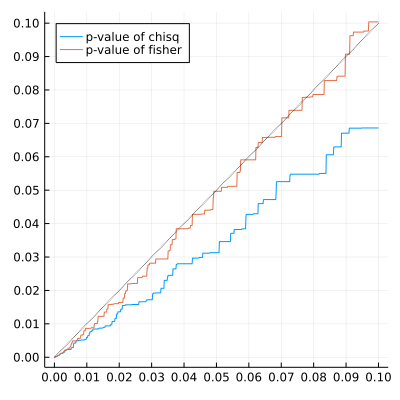

In [5]:
myecdf(A, x) = count(≤(x), A)/length(A)

function rand2bin(a, b, c, d)
    m, n = a + b, c + d
    s, t = a + c, b + d
    N = s + t
    bin1 = Binomial(m, s/N)
    bin2 = Binomial(n, s/N)
    k, l = rand(bin1), rand(bin2)
    k, m-k, l, n-l
end

@time X = [rand2bin(A...) for _ in 1:10^5]
@time p_chisq = pval_fisher.(X)
@time p_fisher = pval_chisq.(X)
@time f_chisq = ecdf(p_chisq)
@time f_fisher = ecdf(p_fisher)
x = range(0, 0.1, 1001)
plot(; legend=:topleft)
@time plot!(x, x -> f_chisq(x); label="p-value of chisq")
@time plot!(x, x -> f_fisher(x); label="p-value of fisher")
plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot)
plot!(; xtick=0:0.01:0.1, ytick=0:0.01:0.1)
plot!(; size=(400, 400))

In [6]:
using RCall

In [7]:
@rput A
R"resA = fisher.test(A)"
@rget resA

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.0885646
  :conf_int    => [0.838987, 18.9579]
  :estimate    => 3.31231
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Fisher's Exact Test for Count Data"
  :data_name   => "A"

In [8]:
L, U = resA[:conf_int]


2-element Vector{Float64}:
  0.8389872803385965
 18.95788039040183

In [9]:
@rput B
R"resB = fisher.test(B)"
@rget resB

OrderedCollections.OrderedDict{Symbol, Any} with 7 entries:
  :p_value     => 0.253623
  :conf_int    => [0.470964, 1.21877]
  :estimate    => 0.759116
  :null_value  => 1.0
  :alternative => "two.sided"
  :method      => "Fisher's Exact Test for Count Data"
  :data_name   => "B"